# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Описание полей
* BeginDate - дата начала пользования услугами.
* EndDate - дата окончания пользования услугами.
* Type - тип оплаты: ежемесячный, годовой и т.д.
* PaperlessBilling - электронный платежный документ
* PaymentMethod - способ оплаты.
* MonthlyCharges - ежемесячные траты на услуги
* TotalCharges - всего потрачено денег на услуги
* Dependents - наличие иждивенцев
* Senior Citizen - наличие пенсионного статуса по возрасту
* Partner - наличие супруга(и)
* MultipleLines - наличие возможности ведения параллельных линий во время звонка.
* gender - пол клиента

### План 
1. [Первичное ознакомление с данными.](#part_1) Загрузить датафремы, провести первичный анализ данных. Наметить план дальнейшей работы с данными.
2. [Предобработка данных](#part_2) для анализа. Проверить и устранить наличие пропусков, явных дубликатов. Привести к необходимым типам данных. Сделать промежуточные выводы.
3. [Анализ данных](#part_3). Провести исследование данных, проверить распределение, выявить есть аномальные выбросы и взаимосвязи между данными. Сформулировать промежуточные выводы.
4. [Подготовка данных к обучению](#part_4). Выделение признаков и целевого для обучения. Разделение датасета на выборки, а также закодировать категориальные признаки.
5. [Анализ моделей](#part_5). Подбор гиперпараметров, обучение и выбор наилучшей модели для тестирования.
6. [Тестирование](#part_6). Проверка модели на тестовой выборке. 
7. Сформулировать [общий вывод](#part_7) по результатам проведенного исследования.

<a id='part_1'></a>
# Первичное ознакомление с данными

In [1]:
!pip install phik==0.10.0
!pip install category_encoders
!pip install xgboost

In [2]:
import pandas as pd
import os.path
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik
import category_encoders as ce
import matplotlib

from scipy import stats as st
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, accuracy_score, roc_curve
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier


warnings.filterwarnings('ignore')
CV = 5
RANDOM_STATE = 240423

In [3]:
data_contract = pd.read_csv('/datasets/contract_new.csv')    
data_personal = pd.read_csv('/datasets/personal_new.csv')
data_internet = pd.read_csv('/datasets/internet_new.csv')
data_phone = pd.read_csv('/datasets/phone_new.csv')

In [4]:
def info_df(data):
    print('*' * 100)
    print(data.info())
    print('*' * 100)
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('*' * 100)  
    print('Кол-во пропусков:')
    print(data.isna().sum())
    print('*'* 100)
    print('Кол-во неявных дубликатов в столбце customerID:')
    print(data['customerID'].duplicated().value_counts())
    print('*'* 100)

In [5]:
data_contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
241,6614-FHDBO,2014-02-01,2016-12-01,Two year,No,Bank transfer (automatic),109.20,3712.8
6172,6379-RXJRQ,2019-01-01,No,Month-to-month,Yes,Electronic check,70.10,911.3
521,4109-CYRBD,2017-09-01,No,Month-to-month,Yes,Electronic check,51.60,1586.18
6040,0519-XUZJU,2019-10-01,No,Month-to-month,No,Mailed check,70.75,283.0
1484,2277-BKJKN,2014-03-01,No,Two year,Yes,Electronic check,99.20,7184.06


In [6]:
info_df(data_contract)

****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
****************************************************************************************************
Количество явных дубликатов: 0
****************************************************************************************************
Кол-во пропусков:
customerID   

In [7]:
data_contract['TotalCharges']. value_counts()

           11
20.45       6
101.0       5
21.53       4
40.1        4
           ..
4357.5      1
3509.55     1
2530.8      1
2599.1      1
7251.82     1
Name: TotalCharges, Length: 6658, dtype: int64

Датафрейм с информацией о договорах содержит 8 столбцов и 7043 строки. Пропуски отсутствуют. Дубликаты не обнаружены. 

 Необходимо привести названия столбцов к общепринятому стилю написания. Поскольку данные в столбце BeginDate и EndDate содержат информацию о дате заключения и окончания договора, то необходимо привести к соответствующему типу данных. Столбец TotalCharges содержит неявный пропуск значения ввиде пробела, который необходимо заменить на 0 и все данные в этом столбце привести к типу float. 
 
 Так же в столбце EndDate присутствуют договоры с записью NO (действующий договор), это значение необходимо заменить например датой выгрузки данных - 1 февраля 2020 года.

In [8]:
data_personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
5502,3755-JBMNH,Male,1,Yes,No
1148,7851-WZEKY,Female,0,No,No
6999,2108-XWMPY,Male,0,No,No
3097,2410-CIYFZ,Male,0,No,Yes
5186,3776-EKTKM,Female,1,No,No


In [9]:
info_df(data_personal)

****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
****************************************************************************************************
Количество явных дубликатов: 0
****************************************************************************************************
Кол-во пропусков:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
****************************************************************************

Датафрейм с информацией о клиентах содержит 5 столбцов и 7043 строки. Пропуски отсутствуют. Дубликаты не обнаружены. 
Необходимо привести названия столбцов к общепринятому стилю написания. 

In [10]:
data_internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3142,7754-IXRMC,DSL,No,No,No,No,No,No
362,1090-ESELR,Fiber optic,Yes,Yes,No,Yes,Yes,Yes
3633,9800-ONTFE,Fiber optic,No,No,No,No,No,No
4094,7661-CPURM,Fiber optic,No,No,No,Yes,No,Yes
1740,4312-GVYNH,DSL,Yes,No,Yes,Yes,No,Yes


In [11]:
info_df(data_internet)

****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
****************************************************************************************************
Количество явных дубликатов: 0
****************************************************************************************************
Кол-во пропусков:
customerID          0
InternetServi

Датафрейм с информацие об интернет-услугах содержит 8 столбцов и 5517 строки. Пропуски отсутствуют. Дубликаты не обнаружены. Необходимо превести названия столбцов к общепринятому стилю написания. Так же стоит учесть, что в этом датафрейме строк меньше, чем в предыдущих датафрейма. Из-за этого возникнут пропуски, которые необходимо будет заполнить. 

In [12]:
data_phone.sample(5)

,customerID,MultipleLines
624,9620-QJREV,No
315,4572-DVCGN,No
1566,7279-NMVJC,No
1758,2484-DGXPZ,No
3015,8058-JMEQO,Yes


In [13]:
info_df(data_phone)

****************************************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
****************************************************************************************************
Количество явных дубликатов: 0
****************************************************************************************************
Кол-во пропусков:
customerID       0
MultipleLines    0
dtype: int64
****************************************************************************************************
Кол-во неявных дубликатов в столбце customerID:
False    6361
Name: customerID, dtype: int64
*******************************************************************************

Датафрейм с информацие об услугах телефонии содержит всего 2 столбца и 6361 строку. Пропуски отсутствуют. Дубликаты не обнаружены. 

 Необходимо превести названия столбцов к общепринятому стилю написания. В данном датафрейме строк меньше, чем в первых двух датафреймах. Это необходимо учесть, что при соединении таблиц образуются пропуски.

**Вывод:** 

1. Были загружены и изучены данных в 4 датафреймах: данные о договорах, персональные данные клиентов, информация о интернет-услугах и данные об услугах телефонии. Явных пропусков и явных дубликатов  в них не обнаружено. Во всех датафреймах названия столбцов необходимо привести к единому общепринятому стилю.
2. Для дальнейшей работы датафреймы соединим в единый при помощи столбца 'customerID'. 
2. Датафрейм с информацией о договорах содержит 8 столбцов и 7043 строки. В данном датафрейме необходимо:
     * В столбцах BeginDate и EndDate содержится информация о дате заключения и окончания договора. Необходимо привести к соответствующему типу данных. 
     * Столбец TotalCharges содержит неявный пропуск значения ввиде пробела. Лучше заменить на 0 и все данные в этом столбце привести к типу float. 
     * В столбце EndDate присутствуют действующие договора('No'). Значение 'No' заменить датой выгрузки данных ('01-02-2020').
3. Датафрейм с информацией о клиентах содержит 5 столбцов и 7043 строки.
4. Датафрейм с информацие об интернет-услугах содержит 8 столбцов и 5517 строки. Стоит учесть, что в этом датафрейме строк меньше 7043 строк. Из-за этого возникнут пропуски, которые необходимо будет заполнить. Образовавшиеся пропуски заполним значением 'No internet', поскольку это означает, что клиент не пользуется интернетом, но он может пользоваться услугами телефонии.
5. Датафрейм с информацие об услугах телефонии содержит всего 2 столбца и 6361 строку. Образовавшиеся пропуски заполним значением 'No phone', поскольку пропуски означают, что данные клиенты не используют услуги телефонии.

<a id='part_2'></a>
# Предобработка данных

Поскольку во всех датафреймах присутствует столбец customerID, то соединение таблиц в единый датафрейм стоит сделать по нему.

In [14]:
data = data_contract.set_index('customerID').join(data_personal.set_index('customerID'))
data = data.join(data_internet.set_index('customerID'))
data = data.join(data_phone.set_index('customerID'))

In [15]:
data.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
3536-IQCTX,2017-02-01,2017-03-01,Month-to-month,No,Electronic check,85.30,87.01,Male,1,Yes,No,Fiber optic,No,No,No,No,No,Yes,Yes
0134-XWXCE,2016-06-01,2019-04-01,One year,No,Bank transfer (automatic),74.85,2544.9,Female,1,No,No,DSL,No,No,Yes,Yes,Yes,Yes,No
4565-EVZMJ,2016-03-01,No,One year,Yes,Mailed check,58.90,2989.76,Female,0,No,No,DSL,Yes,Yes,No,Yes,No,No,No
4139-JPIAM,2015-11-01,2017-06-01,Month-to-month,Yes,Credit card (automatic),44.45,844.55,Male,0,No,No,DSL,Yes,No,No,Yes,No,Yes,NaN
0668-OGMHD,2018-05-01,No,Month-to-month,No,Electronic check,28.50,598.5,Female,0,Yes,No,DSL,Yes,No,No,No,No,No,NaN


Приведем наименование столбцов к общепринятому стилю написания.

In [16]:
data = data.rename(columns={'BeginDate' :'begin_date', 
                           'EndDate' : 'end_date',
                           'Type' : 'type',
                           'PaperlessBilling' : 'paperless_billing',
                           'PaymentMethod' : 'payment_method',
                           'MonthlyCharges' : 'monthly_charges',
                           'TotalCharges' : 'total_charges',
                           'SeniorCitizen' : 'senior_citizen',
                           'Partner' : 'partner',
                           'Dependents' : 'dependents',
                           'InternetService' : 'internet_service',
                           'OnlineSecurity' : 'online_security',
                           'OnlineBackup' : 'online_backup',
                           'DeviceProtection' : 'device_protection',
                           'TechSupport' : 'tech_support',
                           'StreamingTV' : 'streaming_tv',
                           'StreamingMovies' : 'streaming_movies',
                           'MultipleLines' : 'multiple_lines'})

Проверим наличие пропусков после обьединения данных в один датафрейм.

In [17]:
data.isna().sum()

begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64

Как и предполагалось ранее после обьединения появились пропуски. Эти пропуски присутствуют в информации об оказываемых интернет-услугах и об услугах телефонии. Поскольку пропуски означаю, что этому клиенту не предоставляются данные услуги, то заполнить их лучше значениям 'No phone' и 'No internet'.

In [18]:
data['multiple_lines'] = data['multiple_lines'].fillna('No phone')
columns = ['internet_service', 
           'online_security', 
           'online_backup', 
           'device_protection', 
           'tech_support', 
           'streaming_tv', 
           'streaming_movies']

for column in columns:
    data[column] = data[column].fillna('No internet')

Значения в столбце 'end_date' для действующих клиентов заполним датой выгрузки данных - '2020-02-01'. Тоже самое сделаем с неявным пропуском в столбце 'total_charges' на '0'.

In [19]:
data['end_date'] = data['end_date'].replace(['No'], ['2020-02-01'])
data['total_charges'] = data['total_charges'].replace([' '], [0])

Теперь приведем данные в столбцах 'begin_date' и 'end_date' приведем в формат даты. Данные в столбце 'total_charges' приведем к типу float. 

In [20]:
data['begin_date'] = pd.to_datetime(data['begin_date'],format = '%Y-%m-%d')
data['end_date'] = pd.to_datetime(data['end_date'],format = '%Y-%m-%d')
data['total_charges'] = data['total_charges'].astype('float')


Проверим результат заполнения пропусков и преобразования данных.

In [21]:
data['total_charges'].value_counts()

0.00       11
20.45       6
101.00      5
21.53       4
40.10       4
           ..
4357.50     1
3509.55     1
2530.80     1
2599.10     1
7251.82     1
Name: total_charges, Length: 6658, dtype: int64

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   begin_date         7043 non-null   datetime64[ns]
 1   end_date           7043 non-null   datetime64[ns]
 2   type               7043 non-null   object        
 3   paperless_billing  7043 non-null   object        
 4   payment_method     7043 non-null   object        
 5   monthly_charges    7043 non-null   float64       
 6   total_charges      7043 non-null   float64       
 7   gender             7043 non-null   object        
 8   senior_citizen     7043 non-null   int64         
 9   partner            7043 non-null   object        
 10  dependents         7043 non-null   object        
 11  internet_service   7043 non-null   object        
 12  online_security    7043 non-null   object        
 13  online_backup      7043 non-null   object        
 14

**Вывод:**
1. Было сделано обьединение 4-х датафреймов по столбцу 'customer_id' в один, в результате которого образовались пропуски.
2. Поскольку пропуски присутствуют в данных об используемых клиентами услугах интернета и телефонии, то логично заполнить их значением 'No internet'(клиент не пользуется интернет-услугами) и 'No phone'(клиент не использует услуги телефонии). 
3. Неявный пропуск в столбце 'total_charges' заполнили значением '0'.
4. Было сделано преобразование столбцов к необходимым форматам:
    * 'begin_date', 'end_date' - datetime64
    * 'total_charges' - float64.
    
Данные готовы к дальнейшему анализу.

<a id='part_3'></a>
# Анализ данных

Прежде чем приступить к анализу данных добавим некоторую информацию в новые столбцы, которая поможет исследовании. Для начала рассчитаем сколько день прошло между заключение и расторжением договора.  


In [23]:
data['term_contract'] = (data['end_date'] - data['begin_date']).dt.days

Поскольку целевым признаком является дата расторжения контракта, то у нас может быть 2 варианта: клиент остался(0) и клиент ушел(1). Добавим новый столбец в датафрейм.


In [24]:
data['type_client'] = (data['end_date'] != '2020-02-01').astype(int)

Проверим распределение данных.

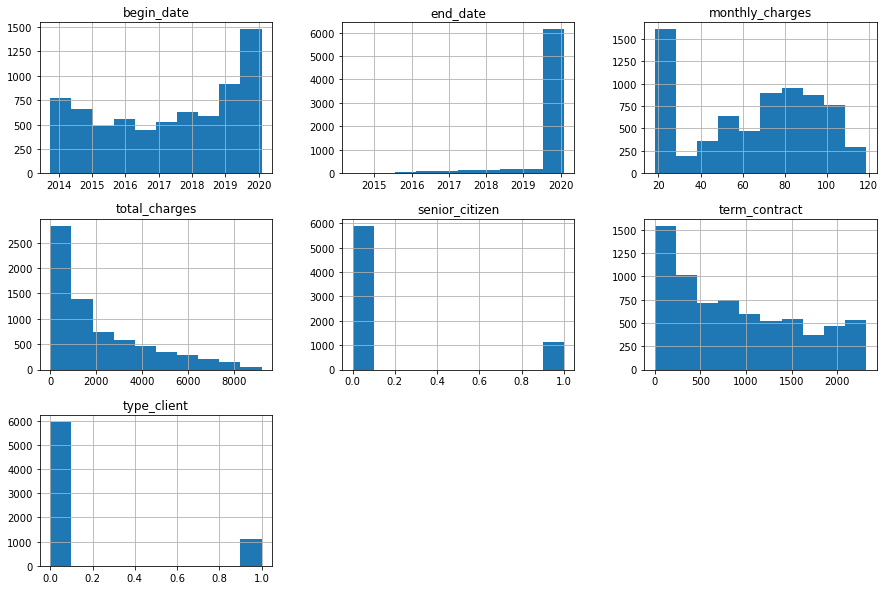

In [25]:
data.hist(figsize=(15, 10))
plt.show()

Исходя из полученных результатов можно сделать следующиее выводы:
* С 2019 года количество новых клиентов увеличивается. 
* Количество клиентов, которые расторгли договор с компанией с 2015 по 2019 имеет небольшой ежегодный прирост.
* Число действующих клиентов значительно превышает число ушедших клиентов.
* В затратах за месяц видно не равномерное распределение.
* Среди клиентов преобладает число людей не достигших пенсионного возраста.
* По длительности контракта преобладает число контрактов с длительностью до 500 дней. Эту категорию стоит рассмотреть более подробно, чтобы сделать какие-либо выводы. Поскольку сюда могут попасть клиенты, которые только заключили контракт.

In [26]:
data.describe()

,monthly_charges,total_charges,senior_citizen,term_contract,type_client
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.162147,898.555729,0.156325
std,30.090047,2112.742814,0.368612,683.130510,0.363189
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000,0.000000
50%,70.350000,1343.350000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


In [27]:
all_cats = data.select_dtypes(include='object')
cat_cols = all_cats.columns

Посмотрим распределение данных категориальных признаков.

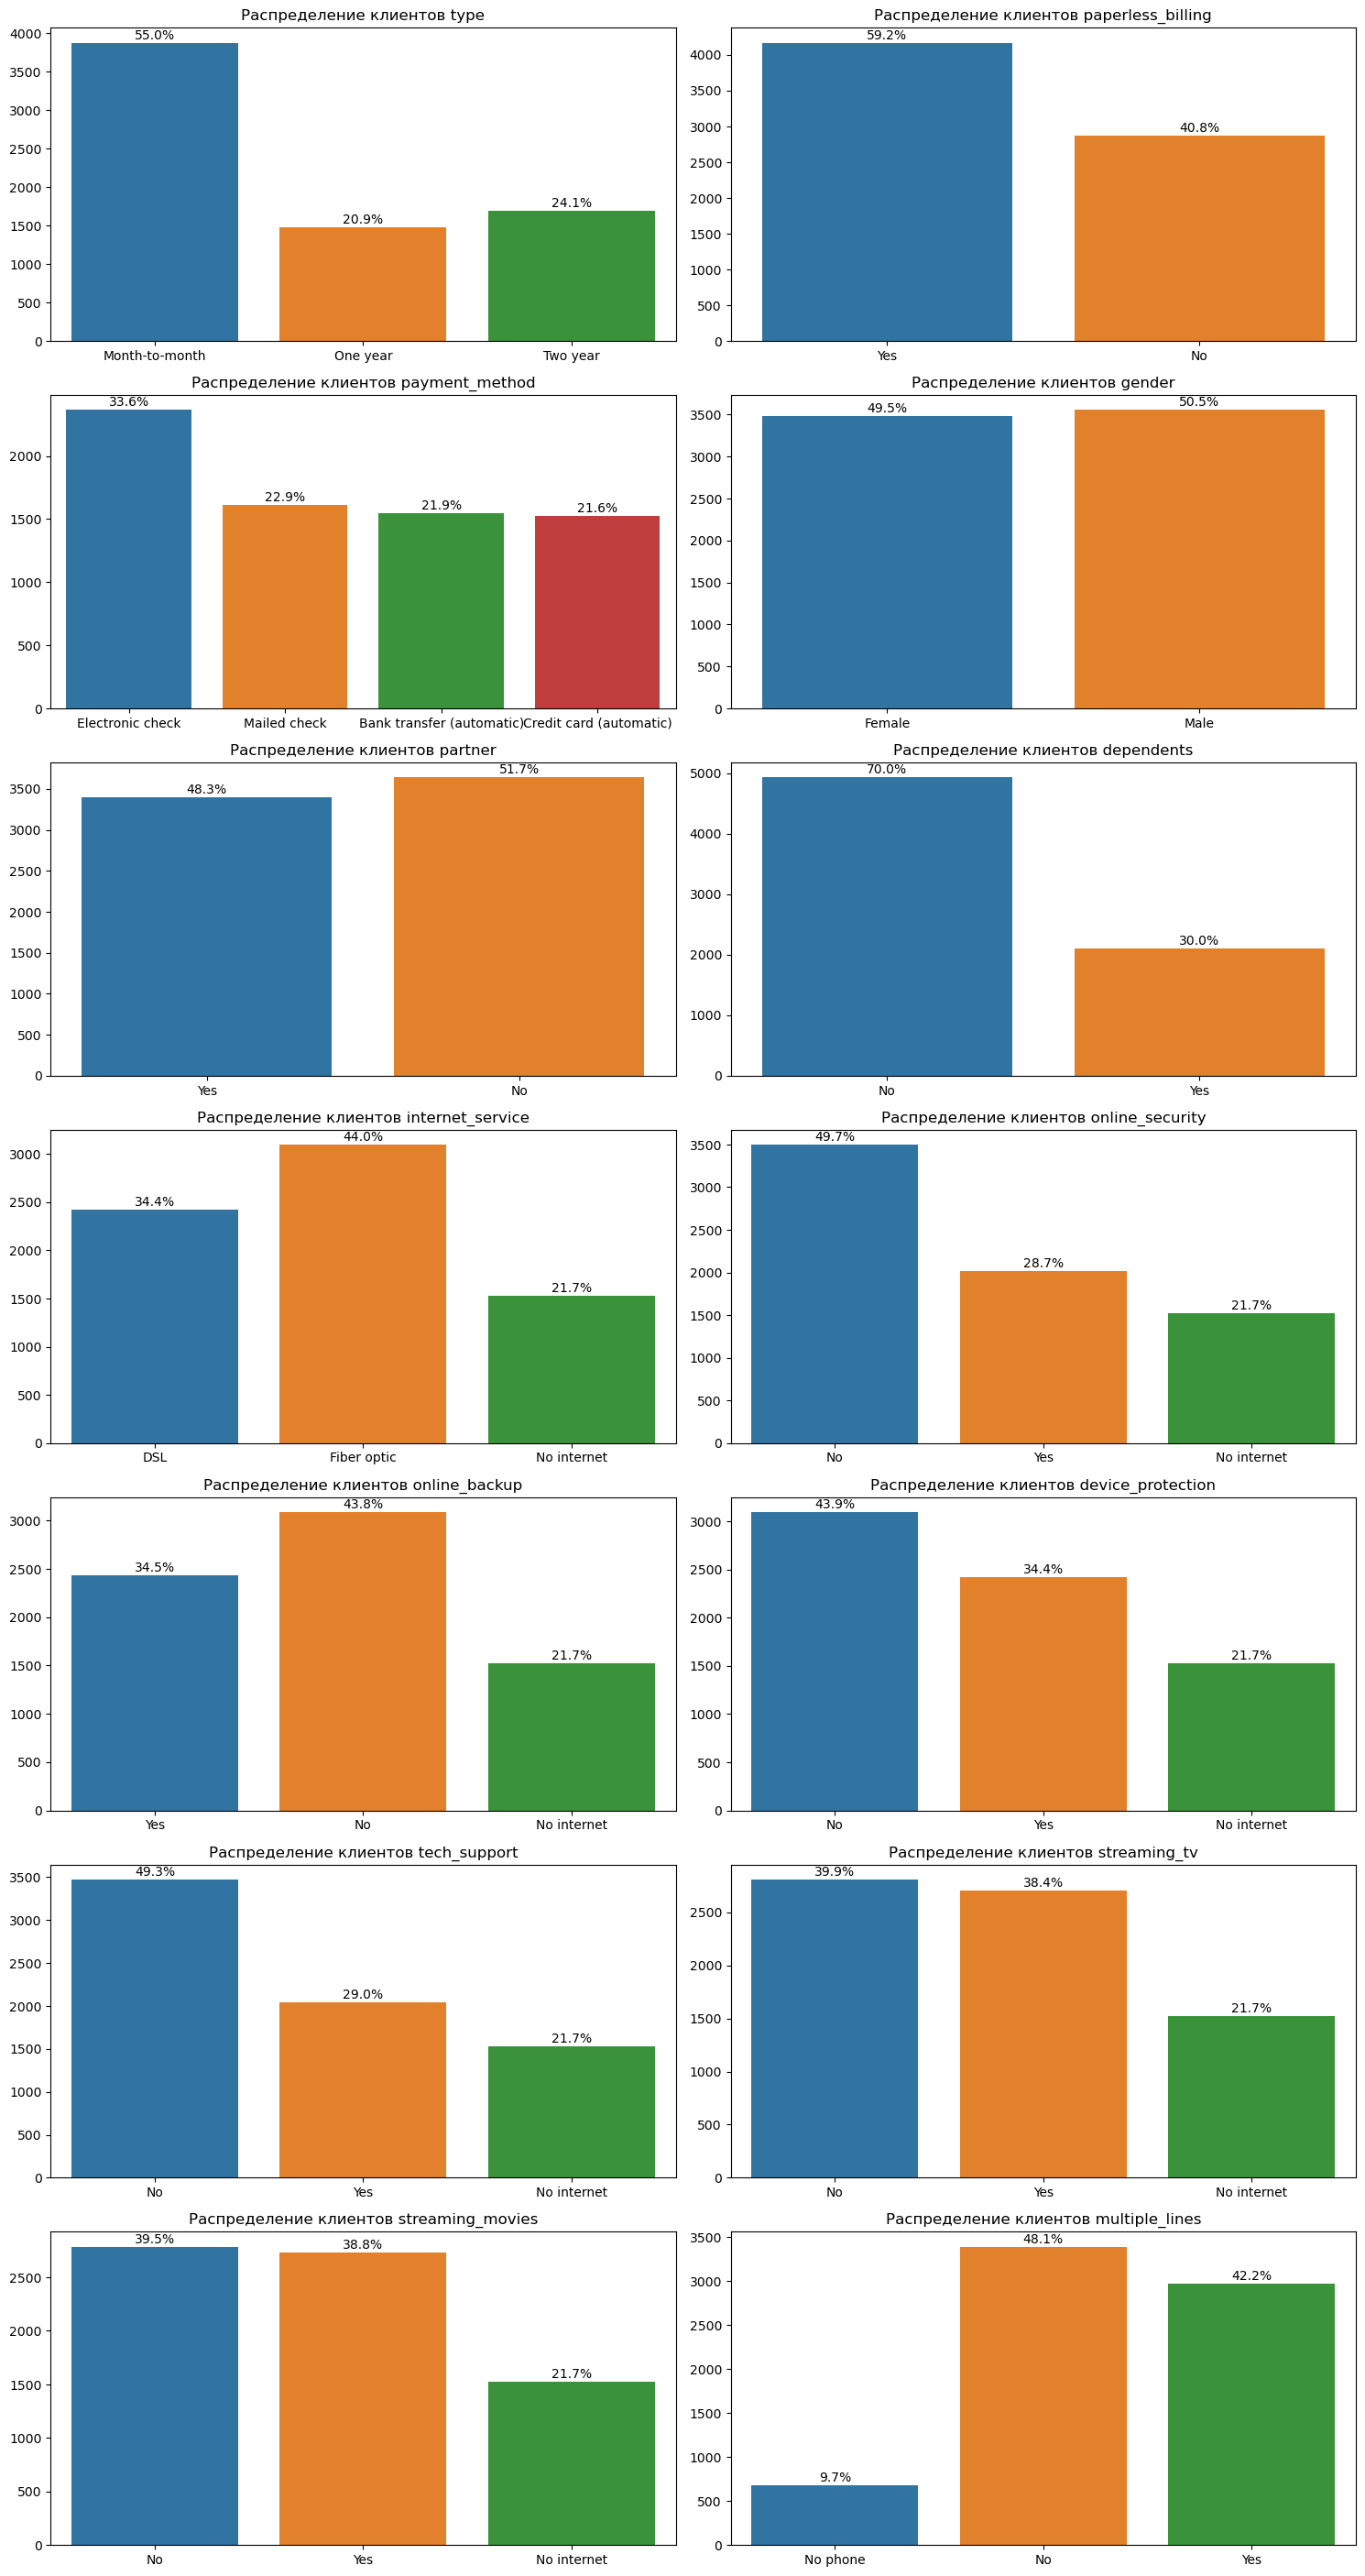

In [28]:
cols = 2
rows = 10
fig = plt.figure(figsize= (15, 40), dpi=100)

for i, col in enumerate(cat_cols):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(f"Распределение клиентов {col}")
    ax.set(xlabel=None, ylabel=None)
    
    total = len(data)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    fig.tight_layout() 
plt.show()

Можно сделать следующие выводы:
 * Наиболее популярный договор с ежемесячной оплатой.
 * Клиенты предпочитают получать электронный плаиежный документ и с его помощью оплачивать услуги.
 * Наиболее популярный способ подключения интернета - оптоволокно.
 * Гендерное распределение и наличие/отсутствие партнера среди клиентов примерно одинаковое. При этом у большинства клиентов нет иждивенцев.
 * Большинство клиентов не пользуются дополнительными интернет-услугами.

 

Теперь посмотрим распределение данных категориальных признаков с учетом целевого.

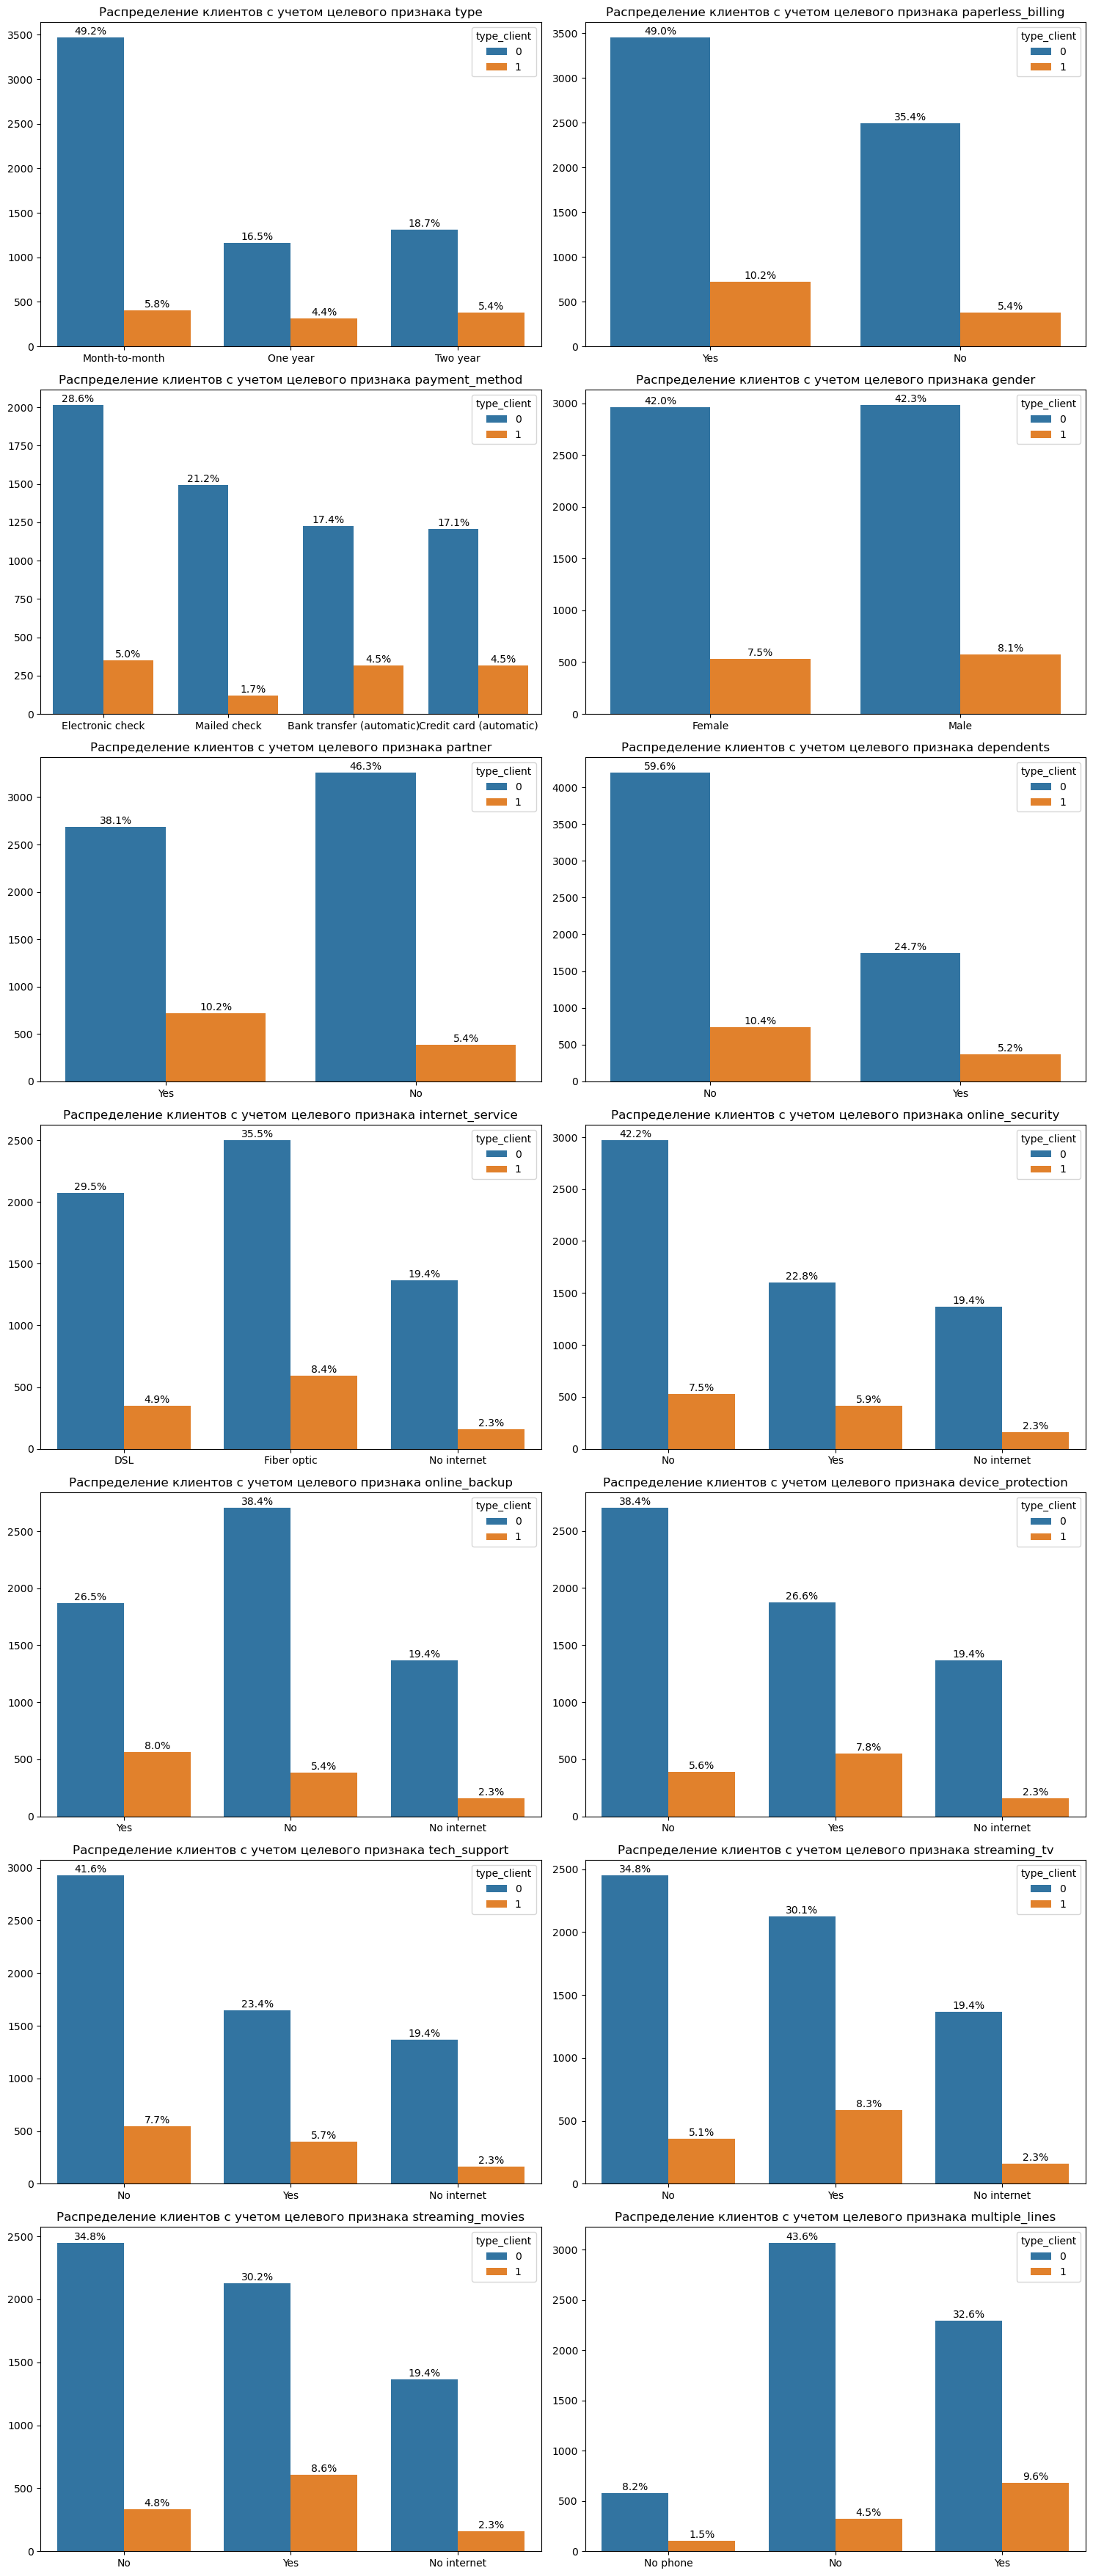

In [29]:
cols = 2
rows = 10
fig = plt.figure(figsize= (15,50), dpi=100)

for i, col in enumerate(cat_cols):
    ax=fig.add_subplot(rows, cols, i+1)
    sns.countplot(x=data[col], hue="type_client", data=data, ax=ax)
    ax.set_title(f"Распределение клиентов с учетом целевого признака {col}")
    ax.set(xlabel=None, ylabel=None)
    
    total = len(data)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')
    fig.tight_layout() 
plt.show()

По полученным результатам можно сделать следующие интересные выводы:
* Клиенты, получающие электронный платежный документ чаще отказываются от услуг компании. Возможно это связано с тем, что получая и оплачивая услуги по безналу расчету подразумевает наличие личного кабинета, в котором можно легко расторгнуть договор.
* Гендерный признак не оказывает существенного влияния на отказ клиента от услуг компании., а вот наличие партнера повышает шансы отказа от услуг.
* Клиенты, использующие подключение интернета по щптоволокну чаще отказываются от услуг компании. 


Посмотрим через какое примерно время клиенты обычно расторгают договор.

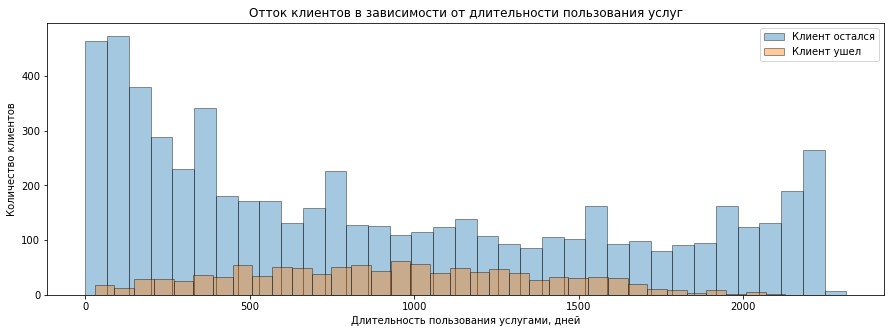

In [30]:
data.groupby('type_client')['term_contract'].plot(kind='hist', bins=35, alpha=0.4, figsize=(15, 5), edgecolor = 'black')
plt.legend(['Клиент остался', 'Клиент ушел'])
plt.title('Отток клиентов в зависимости от длительности пользования услуг')
plt.xlabel('Длительность пользования услугами, дней')
plt.ylabel('Количество клиентов')
plt.show()

Вероятность того, что клиент откажется от услуг компании в период от 0 до 1000 дней возрастает. После прохождения этого порога клиенты уходят реже.

Посмотрим как распределяется уход клиента и ежемесячные затраты.

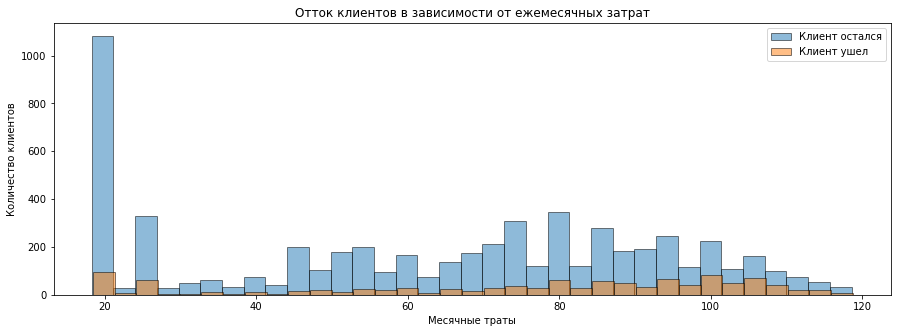

In [31]:
data.groupby('type_client')['monthly_charges'].plot(kind='hist', bins=35, alpha=0.5, figsize=(15, 5), edgecolor = 'black')
plt.legend(['Клиент остался', 'Клиент ушел'])
plt.title('Отток клиентов в зависимости от ежемесячных затрат')
plt.xlabel('Месячные траты')
plt.ylabel('Количество клиентов')
plt.show()

На графике видно, что с увеличением ежемесячного платежа шансы того, что клиент уйдет повышаются. Так же наблюдается повышенное число ушедших клиентов с минимальными ежемесячными затратами. Возможно в этом числе имеются молодые люди(например, студенты), которые нашли компанию с наиболее выгодным предложением или более низкой стоимостью услуг.

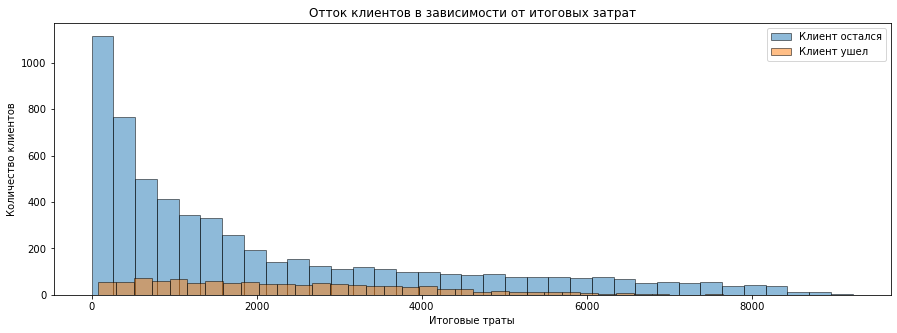

In [32]:
data.groupby('type_client')['total_charges'].plot(kind='hist', bins=35, alpha=0.5, figsize=(15, 5), edgecolor = 'black')
plt.legend(['Клиент остался', 'Клиент ушел'])
plt.title('Отток клиентов в зависимости от итоговых затрат')
plt.xlabel('Итоговые траты')
plt.ylabel('Количество клиентов')
plt.show()

Зависимость между итоговыми затратами и уходом клиента из компании не сильно наблюдается. Скорее всего это связано с тем, что больше влияния все же оказывает ежемесячный платеж и длительность договора. 

Посмотрим корреляцию признаков.

In [33]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'term_contract', 'type_client']


,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,term_contract,type_client
begin_date,1.00,0.55,0.77,0.08,0.46,0.42,0.77,0.01,0.05,0.47,...,0.19,0.46,0.50,0.50,0.46,0.42,0.43,0.47,0.98,0.45
end_date,0.55,1.00,0.29,0.06,0.17,0.17,0.22,0.02,0.09,0.18,...,0.12,0.17,0.24,0.23,0.15,0.19,0.20,0.25,0.40,1.00
type,0.77,0.29,1.00,0.11,0.28,0.39,0.47,0.00,0.09,0.18,...,0.51,0.64,0.58,0.63,0.67,0.55,0.55,0.24,0.63,0.09
paperless_billing,0.08,0.06,0.11,1.00,0.37,0.47,0.20,0.00,0.24,0.01,...,0.23,0.21,0.20,0.20,0.20,0.20,0.20,0.10,0.03,0.08
payment_method,0.46,0.17,0.28,0.37,1.00,0.40,0.34,0.00,0.29,0.24,...,0.32,0.32,0.29,0.30,0.32,0.28,0.29,0.17,0.35,0.21
monthly_charges,0.42,0.17,0.39,0.47,0.40,1.00,0.71,0.01,0.30,0.20,...,0.92,0.81,0.82,0.83,0.82,0.86,0.86,0.71,0.39,0.23
total_charges,0.77,0.22,0.47,0.20,0.34,0.71,1.00,0.00,0.14,0.38,...,0.49,0.52,0.55,0.56,0.53,0.56,0.55,0.47,0.85,0.30
gender,0.01,0.02,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
senior_citizen,0.05,0.09,0.09,0.24,0.29,0.30,0.14,0.00,1.00,0.02,...,0.16,0.13,0.11,0.11,0.14,0.11,0.11,0.09,0.06,0.09
partner,0.47,0.18,0.18,0.01,0.24,0.20,0.38,0.00,0.02,1.00,...,0.00,0.09,0.09,0.10,0.08,0.08,0.08,0.09,0.45,0.23


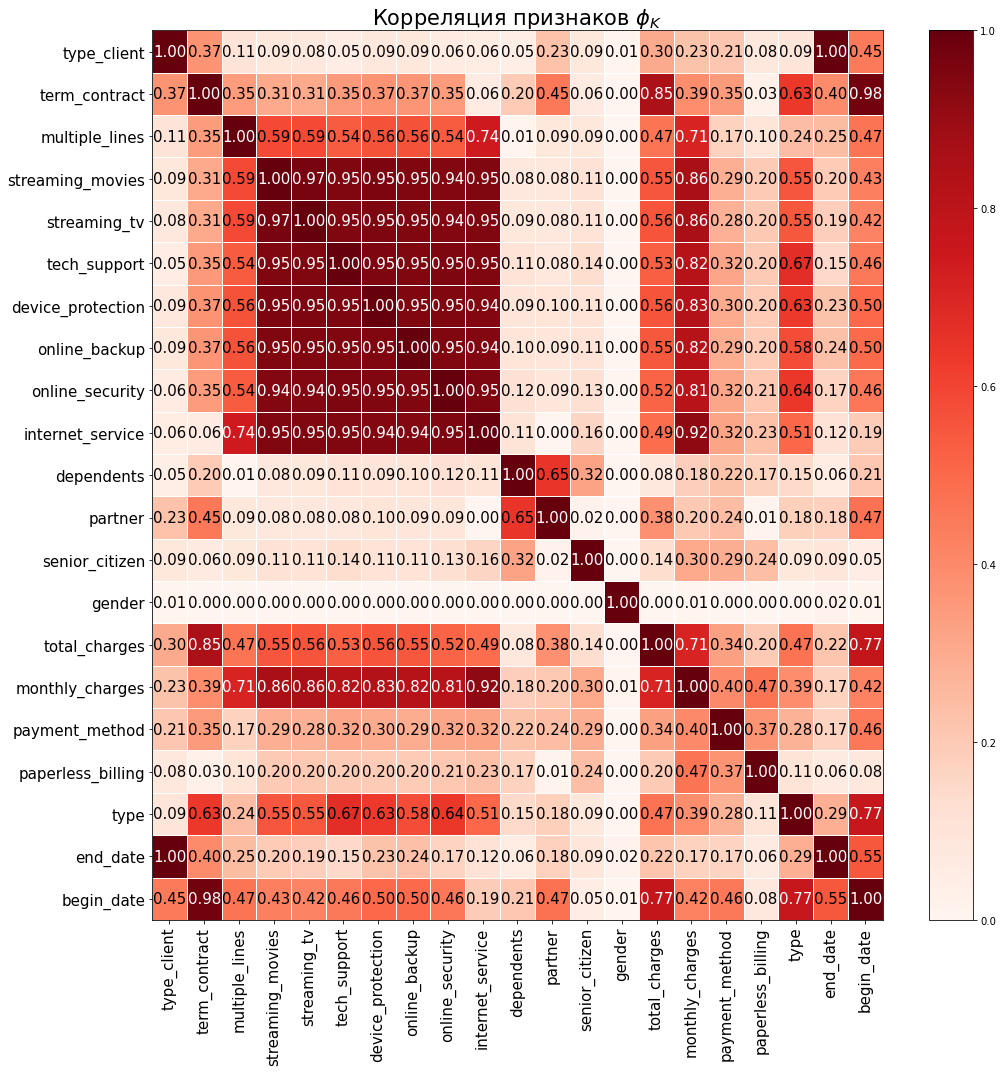

In [34]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"Корреляция признаков $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 15))
plt.tight_layout()

Видно, что дата заключения контракта очень сильно влияет на длительность контракт, а дата рассторжения контракта сильно влияет на целевой признак, поэтому необходимо будет удалисть столбцы begin_date и end_date.  

Остальные признаки не имеют сильно корреляции с целевым. При этом у некоторых из них наблюдается достаточно сильная взаимосвязь между собой(например ежемесячный платеж - итоговая сумма, ежемесячный платеж - дополнительные услуги). В нашем случае total_charges можно тоже удалить.

In [35]:
data = data.drop(['begin_date', 'end_date', 'total_charges'], axis=1)

Проверим одну гипотезу: большинство клиентов, которые расторгли договор, ушли в первые 3 года.

**H0 - нулевая гипотеза:**
 * Среднее значение длительности договора ушедших клиентов в пределах 1095 дней (3 года) 
 
**H1 - альтернативная гипотеза:**
 * Среднее значение длительности договора ушедщих клиентов больше 1095 дней.

In [36]:
term_contract = data.query('type_client == 1')['term_contract']

optimal_value = 1095
alpha = .05
results =st.ttest_1samp(term_contract, optimal_value)

print('p-значение: ', results.pvalue / 2)

if (results.pvalue / 2 < alpha) and (term_contract.mean() > optimal_value):
    print("Отвергаем нулевую гипотезу")
    
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  5.368257192146336e-33
Не получилось отвергнуть нулевую гипотезу


 Не получилось отвергнуть нулевую гипотезу, следовательно мы можем утверждать, что в среднем клиенты отказываются от услуг компании в течении 3 лет.

**Выводы:**

Был проведен анализ данных. В результате анализа было выявлено следующее:

* Количество клиентов, которые расторгли договор с компанией с 2015 по 2019 имеет небольшой ежегодный прирост. При этом с 2019 года наблюдается увеличение числа клиентов новых клиентов. При этом число действующих клиентов значительно превышает число оттока клиентов.
* Большинство клиентов не имеют детей(иждивенцев) и не достигли пенсионного возраста. Наиболее популярный тип договора с ежемесячной оплатой без использования дополнительных услуг. При этом клиенты предпочитают получать электронный платежный документ и с его помощью оплачивать предоставляемые услуги компании. Мужчин и женщин среди клиентов примерно поравну.

* Наиболее популярный способ подключения интернета - оптоволокно.

Поскольку целевым признаком является ушел клиент или нет, то было преведено исследование распределения данных по признакам с учетом этого. Вот что было обнаружено:

* Клиенты, получающие электронный платежный документ чаще отказываются от услуг компании. Возможно это связано с тем, что получая и оплачивая услуги по безналу расчету подразумевает наличие личного кабинета, в котором можно легко расторгнуть договор. Гендерный признак не оказывает существенного влияния на отказ клиента от услуг компании., а вот наличие партнера повышает шансы отказа от услуг.

* Клиенты, использующие подключение интернета по оптоволокну чаще отказываются от услуг компании. Возможно проблема в качестве предоставляемой услуги: низнакая скорость интернета, плохая техподдержка.

* Так же было обнаружено, что с увеличением ежемесячного платежа шансы того, что клиент уйдет повышаются. Наблюдается повышенное число ушедших клиентов с минимальными ежемесячными затратами. Возможно в этом числе имеются молодые люди(например, студенты), которые нашли компанию с наиболее выгодным предложением или более низкой стоимостью услуг.

* Была сформулирована и подтверждена гипотеза, что в среднем клиенты отказываются от услуг компании в течении 3 лет с момента заключения договора.


Была построена матрица корреляции признаков. Она показала, что дата заключения контракта очень сильно влияет на длительность контракт, а дата рассторжения контракта сильно влияет на целевой признак. Так же наблюдается достаточно сильная взаимосвязь между собой некоторых признаков(например ежемесячный платеж - итоговая сумма, ежемесячный платеж - дополнительные услуги).

<a id='part_4'></a>
# Подготовка данных к обучению

Разделим наши данные на 2 выборки в соотношении 3:1:
* Обучающую - 75%
* Тестовая - 25%

 Затем произведем выделение целевого признака в этих выборках.

In [37]:
data_train, data_test = train_test_split(data, test_size=.25, random_state=RANDOM_STATE)

print("Размер обучающей выборки: {:.0%}".format(data_train.shape[0] / data.shape[0]))
print("Размер тестовой выборки: {:.0%}".format(data_test.shape[0] / data.shape[0]))

Размер обучающей выборки: 75%
Размер тестовой выборки: 25%


In [38]:
features_train = data_train.drop(['type_client'], axis=1)
features_test = data_test.drop(['type_client'], axis=1)

target_train = data_train['type_client']
target_test = data_test['type_client']
print(features_train.dtypes)

type                  object
paperless_billing     object
payment_method        object
monthly_charges      float64
gender                object
senior_citizen         int64
partner               object
dependents            object
internet_service      object
online_security       object
online_backup         object
device_protection     object
tech_support          object
streaming_tv          object
streaming_movies      object
multiple_lines        object
term_contract          int64
dtype: object


Поскольку среди признаков имеются категориальные, то необходимо их закодировать. Для кодировки используем Target Encoder. Прежде чем приступить к кодированию категориальных признаков посмотрим на распределение целевого признака в подготовленных выборках.

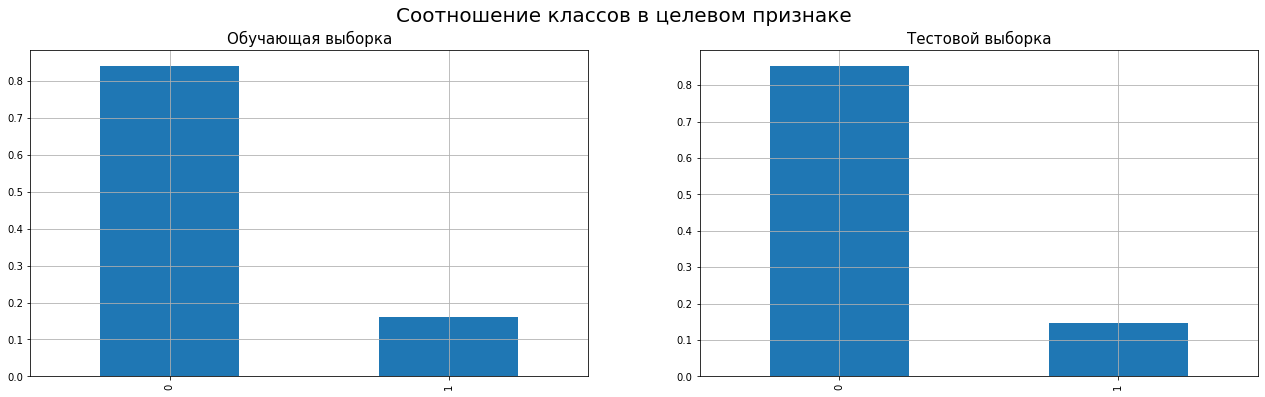

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(22,6))
plt.suptitle('Соотношение классов в целевом признаке', fontsize=20)

class_frequency_train = target_train.value_counts(normalize=True)
class_frequency_train.plot(kind='bar', ax=axes[0]).set_title('Обучающая выборка', fontsize=15)
axes[0].grid()


class_frequency_test = target_test.value_counts(normalize=True)
class_frequency_test.plot(kind='bar', ax=axes[1]).set_title('Тестовой выборка', fontsize=15)
axes[1].grid()
plt.show()


Наблюдается дисбаланс целевого признака. При подборе наилучшей модели будем использовать balanced,поскольку целевая метрика не чувствительна к дисбалансу.

Закодируем категориальные признаки и сразу подготовим таблицу для занесения итоговых результатов.

In [40]:
encoder = ce.TargetEncoder(return_df=True)
features_train_te = encoder.fit_transform(features_train, target_train)
features_train_te.dtypes

type                 float64
paperless_billing    float64
payment_method       float64
monthly_charges      float64
gender               float64
senior_citizen         int64
partner              float64
dependents           float64
internet_service     float64
online_security      float64
online_backup        float64
device_protection    float64
tech_support         float64
streaming_tv         float64
streaming_movies     float64
multiple_lines       float64
term_contract          int64
dtype: object

In [41]:
features_test_te = encoder.transform(features_test)
features_test_te.dtypes

type                 float64
paperless_billing    float64
payment_method       float64
monthly_charges      float64
gender               float64
senior_citizen         int64
partner              float64
dependents           float64
internet_service     float64
online_security      float64
online_backup        float64
device_protection    float64
tech_support         float64
streaming_tv         float64
streaming_movies     float64
multiple_lines       float64
term_contract          int64
dtype: object

In [42]:
index_table = 0
table = pd.DataFrame(columns=['Модель', 'AUC_ROC', 'Accuracy', 'F1'])

**Вывод:**

 * Данные были разделены на 2 выборки: обучающую и тестовую в соотношении 3:1. Выделены признаки и целевой, а также проведен анализ на дисбаланс в целевом признаке. В результате анализа был обнаружен сильный дисбаланс, для борьбы с которым будет применять метод балансировки весов. 
 * Была проведена кодировка категориальных признаков методом TargetEncoder.

<a id='part_5'></a>
# Анализ моделей

Для обучения отобрали 5 моделей:
* RandomForestClassifier
* CatboostClassifier
* LGBMClassifier
* XGBClassifier
* AdaBoostClassifier

Перед тем как приступить к обучению моделей и выбору лучшей, создадим две собственные функции:
* Построение ROC-кривой
* Обучение и подбор гиперпараметров.

In [43]:
def roc_plot(fpr, tpr, name):
    roc_plot = plt.figure(figsize=[12,9])
    roc_plot = plt.plot([0, 1], [0, 1], linestyle='--', label='Случайная модель')
    roc_plot = plt.plot(fpr, tpr, label=name)

    plt.xlim([0,1])
    plt.ylim([0,1])
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
    plt.legend(loc='lower right', fontsize='x-large')
    plt.title(f"ROC-кривая {name}")
    plt.show()
    
    return  roc_plot

In [44]:
def grid_model(model, params, name):
    
    scores = {'ROC_AUC': 'roc_auc', 'F1': 'f1', 'AUC': 'accuracy'}
    
    pipeline = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    
    grid_model = GridSearchCV(pipeline, 
                              params, 
                              cv=CV, 
                              scoring=scores, 
                              refit='ROC_AUC', 
                              return_train_score=True, 
                              n_jobs=-1)
    grid_model.fit(features_train_te, target_train)
    
    
    roc_auc = grid_model.best_score_
    f1 = grid_model.cv_results_['mean_test_F1'][grid_model.best_index_]
    accuracy = grid_model.cv_results_['mean_test_AUC'][grid_model.best_index_]
    
    best_estimator = grid_model.best_estimator_
    
    probabilities_valid = best_estimator.predict_proba(features_test_te)
    probabilities_one_valid = probabilities_valid[:, 1]
    
    fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
    
    print('Модель с лучшими гиперпараметрами:')
    print(best_estimator)
    print('ROC-AUC на тренировочной выборке: {:.5f}'.format(roc_auc)) 
    roc_plot(fpr, tpr, name)
    
    pd.DataFrame(data={'score': best_estimator['clf'].feature_importances_}, 
                 index=features_train_te.columns).sort_values(by='score').plot(kind='barh', 
                                                                               grid=True, 
                                                                               figsize=(6,6), 
                                                                               legend=False,
                                                                               title=f"Важность признаков для модели {name}",
                                                                               xlabel='Признаки')

    return roc_auc, f1, accuracy, best_estimator

# RandomForestClassifier

Обучение модели случайного леса и подбор гиперпараметров без учета дисбаланса. Результаты занесем в итоговую таблицу.

In [45]:
param_grid = {'clf__n_estimators': [25, 50, 100, 150],
              'clf__min_samples_leaf': [1, 2, 5, 10],
              'clf__min_samples_split': [2, 5, 10, 15, 100]}


Модель с лучшими гиперпараметрами:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(min_samples_split=100, n_estimators=150,
                                        random_state=240423))])
ROC-AUC на тренировочной выборке: 0.82047


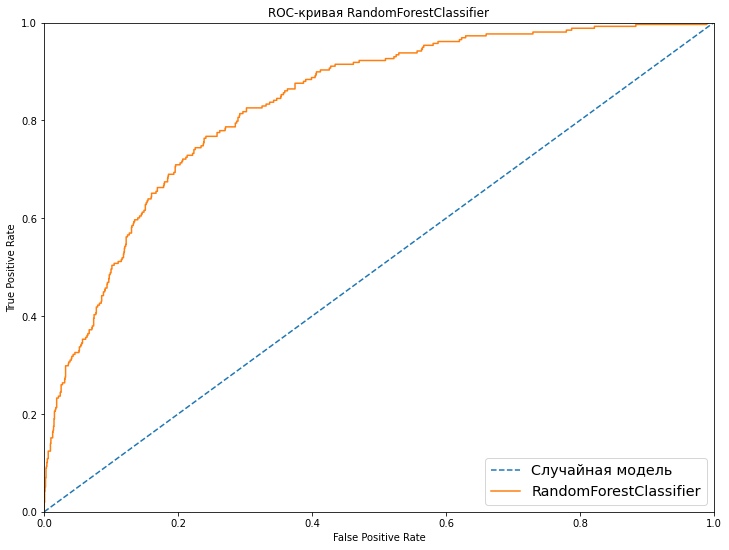

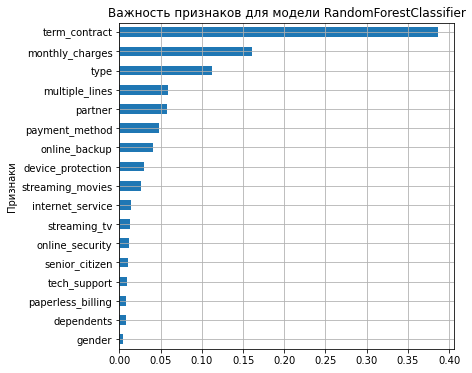

In [46]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

roc_auc_rf, f1_rf, accuracy_rf, best_rf_model = grid_model(rf_model, param_grid, 'RandomForestClassifier')

In [47]:
index_table += 1
table.loc[index_table] = ['RandomForestClassifier', roc_auc_rf, accuracy_rf, f1_rf]
table

,Модель,AUC_ROC,Accuracy,F1
1,RandomForestClassifier,0.82047,0.847217,0.093732


# RandomForestClassifier + balanced

Обучение и подбор гиперпараметров для модели случайного леса с учетом дисбаланаса.

In [48]:
rf_model_bl = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_leaf=10, n_estimators=150,
                                        random_state=240423))])
ROC-AUC на тренировочной выборке: 0.82148


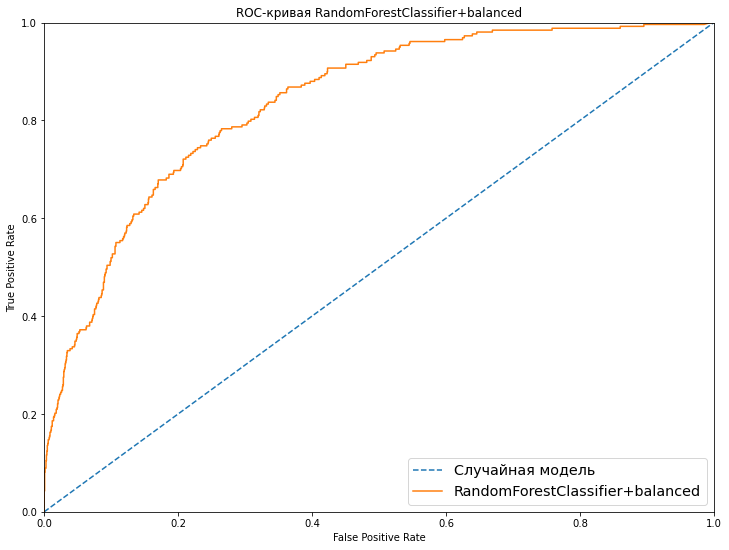

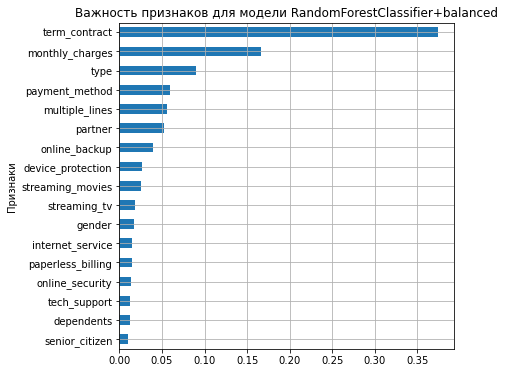

In [49]:
roc_auc_rf_bl, f1_rf_bl, accuracy_rf_bl, best_rf_model_bl = grid_model(rf_model_bl, param_grid, 'RandomForestClassifier+balanced')

In [50]:
index_table += 1
table.loc[index_table] = ['RandomForestClassifier+balanced', roc_auc_rf_bl, accuracy_rf_bl, f1_rf_bl]
table

,Модель,AUC_ROC,Accuracy,F1
1,RandomForestClassifier,0.820470,0.847217,0.093732
2,RandomForestClassifier+balanced,0.821483,0.787959,0.496057


Метрика AUC_ROC показала небольшое повышение, F1 значительно улучшило свои показатели. А вот метрика accuracy немного снизилась.

Наиболее важными признаками для модели RandomForestClassifier являются длительность контракта, ежемесячные траты, тип договора. Наименее важными признаками оказалась информация о предоставлении дополнительных услуг, наличие пенсионного возраста.

# LGBMClassifier

Обучение и подбор гиперпараметров модели LGBMClassifier без учета дисбаланса.

In [51]:
lgbm_class_param = {'clf__learning_rate': [0.1, 0.05, 0.3, 0.01, 0.6], 
                    'clf__max_depth': [-1, 3, 5, 6], 
                    'clf__n_estimators': [50, 100, 150, 500, 1000],
                   'clf__num_threads':[1] #Код ревьюера
                   }

In [52]:
lgbm_class = LGBMClassifier(random_state=RANDOM_STATE)

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
Модель с лучшими гиперпараметрами:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LGBMClassifier(max_depth=3, n_estimators=1000, num_threads=1,
                                random_state=240423))])
ROC-AUC на тренировочной выборке: 0.90314


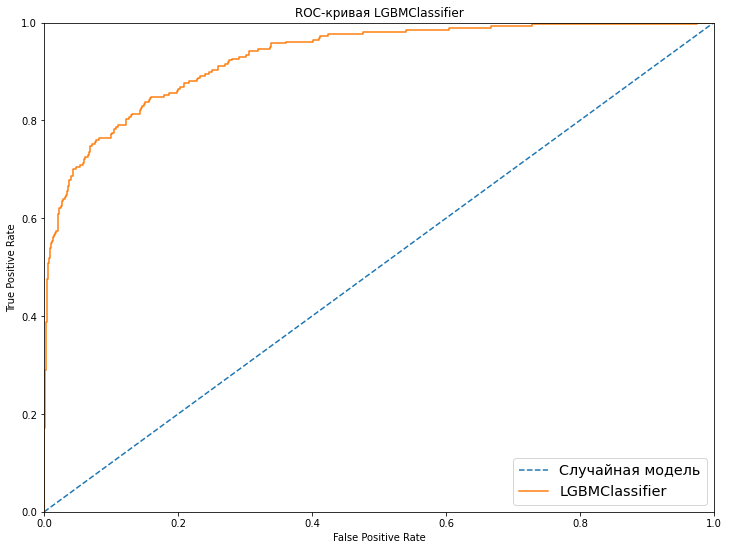

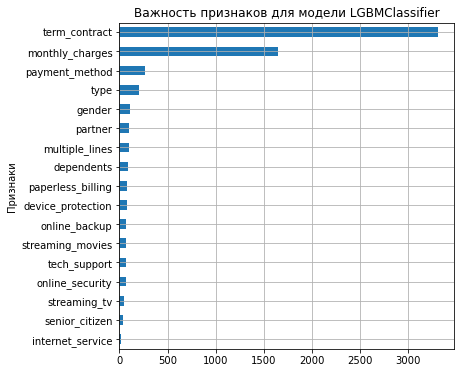

In [53]:
roc_auc_lgbm, f1_lgbm, accuracy_lgbm, best_lgbm_model = grid_model(lgbm_class, lgbm_class_param, 'LGBMClassifier')

In [54]:
index_table += 1
table.loc[index_table] = ['LGBMClassifier', roc_auc_lgbm, accuracy_lgbm, f1_lgbm]
table

,Модель,AUC_ROC,Accuracy,F1
1,RandomForestClassifier,0.820470,0.847217,0.093732
2,RandomForestClassifier+balanced,0.821483,0.787959,0.496057
3,LGBMClassifier,0.903137,0.916129,0.685272


# LGBMClassifier + balanced

Обучение и подбор гиперпараметров модели LGBMClassifier с учетом дисбаланса.

[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
Модель с лучшими гиперпараметрами:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LGBMClassifier(class_weight='balanced', max_depth=3,
                                n_estimators=1000, num_threads=1,
                                random_state=240423))])
ROC-AUC на тренировочной выборке: 0.89762


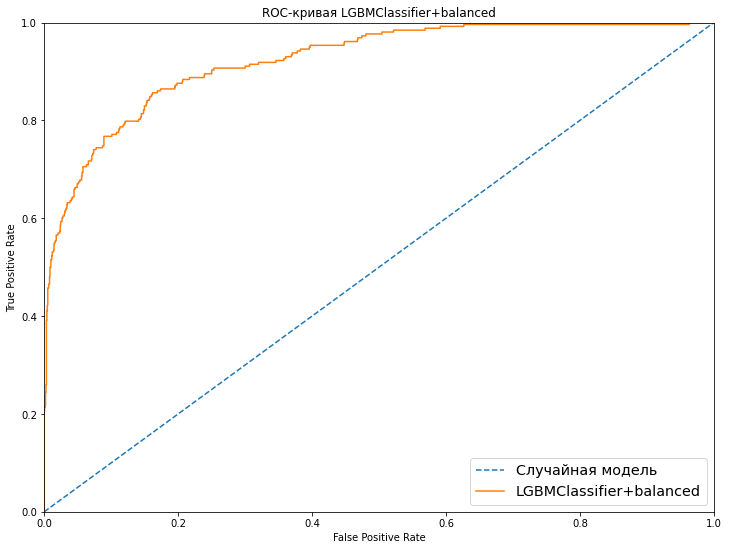

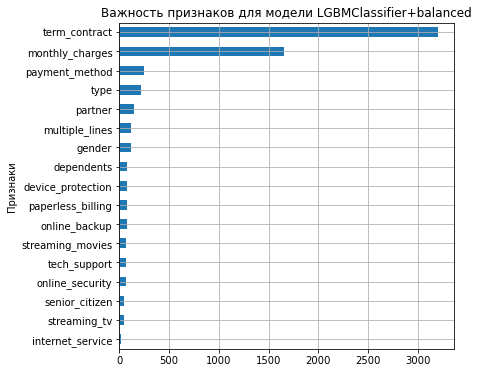

In [55]:
lgbm_class_bl = LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')

roc_auc_lgbm_bl, f1_lgbm_bl, accuracy_lgbm_bl, best_lgbm_model_bl = grid_model(lgbm_class_bl, lgbm_class_param, 'LGBMClassifier+balanced')

In [56]:
index_table += 1
table.loc[index_table] = ['LGBMClassifier+balanced', roc_auc_lgbm_bl, accuracy_lgbm_bl, f1_lgbm_bl]
table

,Модель,AUC_ROC,Accuracy,F1
1,RandomForestClassifier,0.820470,0.847217,0.093732
2,RandomForestClassifier+balanced,0.821483,0.787959,0.496057
3,LGBMClassifier,0.903137,0.916129,0.685272
4,LGBMClassifier+balanced,0.897622,0.878834,0.650486


Применение учета дисбаланса в данной модели снизило показатели всех метрик. С учетом это результата и результата на модели RandomForestClassifier применять учето дисбаланса при обучении моделей не будем.

Наиболее важными признаками при обучении также оказались длительность контракта, ежемесячный платеж, метод оплаты и тип договора. Остальные признаки менее важные.

# CatBoostClassifier

Обучение и подбор гиперпараметров модели CatBoostClassifier.

In [57]:
cat_m = CatBoostClassifier(random_state=RANDOM_STATE)

In [58]:
cat_param = {'clf__iterations': [500], 
             'clf__depth': [3, 5, 7, 10], 
             'clf__learning_rate': [.1, .01, .5, .2], 
             'clf__l2_leaf_reg': [1, 3, 5, 10]}

0:	learn: 0.5689460	total: 148ms	remaining: 1m 13s
1:	learn: 0.4918442	total: 150ms	remaining: 37.4s
2:	learn: 0.4506463	total: 152ms	remaining: 25.2s
3:	learn: 0.4179778	total: 154ms	remaining: 19.1s
4:	learn: 0.3933673	total: 156ms	remaining: 15.4s
5:	learn: 0.3803657	total: 158ms	remaining: 13s
6:	learn: 0.3696358	total: 160ms	remaining: 11.3s
7:	learn: 0.3638342	total: 162ms	remaining: 9.93s
8:	learn: 0.3563658	total: 163ms	remaining: 8.92s
9:	learn: 0.3525049	total: 165ms	remaining: 8.1s
10:	learn: 0.3481258	total: 167ms	remaining: 7.42s
11:	learn: 0.3436859	total: 169ms	remaining: 6.86s
12:	learn: 0.3413726	total: 171ms	remaining: 6.4s
13:	learn: 0.3385152	total: 173ms	remaining: 6s
14:	learn: 0.3363548	total: 175ms	remaining: 5.64s
15:	learn: 0.3353396	total: 176ms	remaining: 5.34s
16:	learn: 0.3337408	total: 178ms	remaining: 5.06s
17:	learn: 0.3328142	total: 180ms	remaining: 4.82s
18:	learn: 0.3314878	total: 182ms	remaining: 4.62s
19:	learn: 0.3298765	total: 184ms	remaining: 4.

173:	learn: 0.1993174	total: 500ms	remaining: 937ms
174:	learn: 0.1990242	total: 502ms	remaining: 933ms
175:	learn: 0.1985797	total: 505ms	remaining: 929ms
176:	learn: 0.1982972	total: 507ms	remaining: 924ms
177:	learn: 0.1981479	total: 509ms	remaining: 920ms
178:	learn: 0.1970234	total: 511ms	remaining: 917ms
179:	learn: 0.1960477	total: 513ms	remaining: 913ms
180:	learn: 0.1955725	total: 516ms	remaining: 909ms
181:	learn: 0.1953523	total: 518ms	remaining: 904ms
182:	learn: 0.1947259	total: 520ms	remaining: 901ms
183:	learn: 0.1940598	total: 522ms	remaining: 897ms
184:	learn: 0.1931853	total: 525ms	remaining: 894ms
185:	learn: 0.1924463	total: 527ms	remaining: 890ms
186:	learn: 0.1918541	total: 530ms	remaining: 886ms
187:	learn: 0.1917148	total: 532ms	remaining: 883ms
188:	learn: 0.1915595	total: 534ms	remaining: 879ms
189:	learn: 0.1913857	total: 536ms	remaining: 875ms
190:	learn: 0.1910175	total: 539ms	remaining: 872ms
191:	learn: 0.1908921	total: 541ms	remaining: 867ms
192:	learn: 

356:	learn: 0.1442328	total: 865ms	remaining: 346ms
357:	learn: 0.1441106	total: 867ms	remaining: 344ms
358:	learn: 0.1440242	total: 868ms	remaining: 341ms
359:	learn: 0.1438767	total: 870ms	remaining: 338ms
360:	learn: 0.1436859	total: 872ms	remaining: 336ms
361:	learn: 0.1434198	total: 874ms	remaining: 333ms
362:	learn: 0.1433483	total: 877ms	remaining: 331ms
363:	learn: 0.1431134	total: 879ms	remaining: 328ms
364:	learn: 0.1428603	total: 881ms	remaining: 326ms
365:	learn: 0.1426721	total: 882ms	remaining: 323ms
366:	learn: 0.1425730	total: 884ms	remaining: 320ms
367:	learn: 0.1423242	total: 886ms	remaining: 318ms
368:	learn: 0.1421947	total: 888ms	remaining: 315ms
369:	learn: 0.1419454	total: 890ms	remaining: 313ms
370:	learn: 0.1417925	total: 892ms	remaining: 310ms
371:	learn: 0.1415129	total: 893ms	remaining: 307ms
372:	learn: 0.1412315	total: 895ms	remaining: 305ms
373:	learn: 0.1412136	total: 897ms	remaining: 302ms
374:	learn: 0.1410614	total: 899ms	remaining: 300ms
375:	learn: 

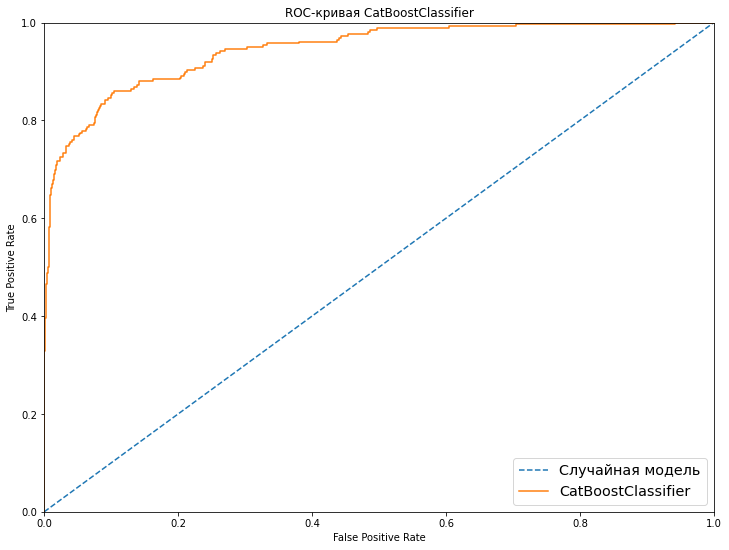

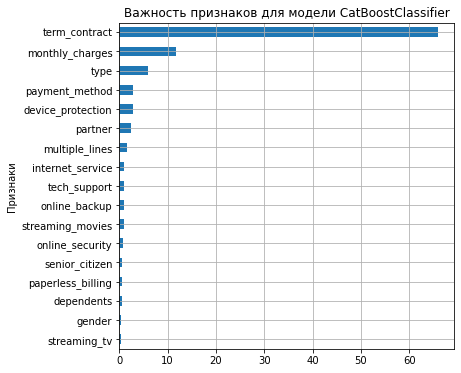

In [59]:
roc_auc_cat, f1_cat, accuracy_cat, best_cat_model = grid_model(cat_m, cat_param, 'CatBoostClassifier')

In [60]:
index_table += 1
table.loc[index_table] = ['CatBoostClassifier', roc_auc_cat, accuracy_cat, f1_cat]
table

,Модель,AUC_ROC,Accuracy,F1
1,RandomForestClassifier,0.820470,0.847217,0.093732
2,RandomForestClassifier+balanced,0.821483,0.787959,0.496057
3,LGBMClassifier,0.903137,0.916129,0.685272
4,LGBMClassifier+balanced,0.897622,0.878834,0.650486
5,CatBoostClassifier,0.926303,0.925404,0.721808


Наиболее важными признаками для модели CatBoostClassifier оказались длительность контракта, ежемесячные платежи и тип договора.

# XGBClassifier

Обучение и подбор гиперпараметров для модели XGBClassifier.

In [61]:
xgb= XGBClassifier(random_state=RANDOM_STATE)

In [62]:
xgb_params={
            'clf__learning_rate': [0.05, 0.1, 0.2],
            'clf__max_depth': [2, 3 , 5 , 7],
            'clf__n_estimators':  range(10,150,10)}

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints

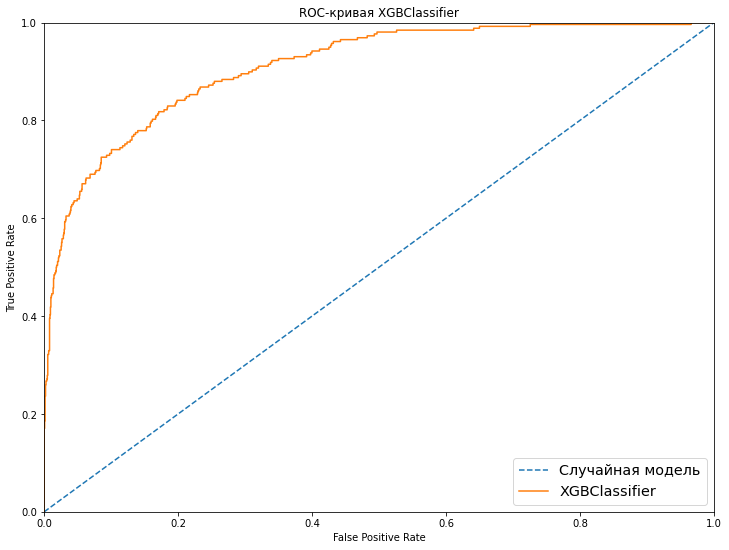

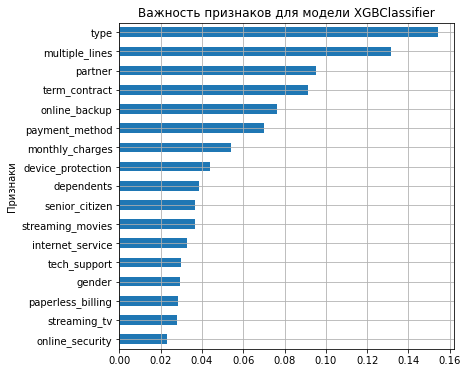

In [63]:
roc_auc_xgb, f1_xgb, accuracy_xgb, best_xgb_model = grid_model(xgb, xgb_params, 'XGBClassifier')

In [64]:
index_table += 1
table.loc[index_table] = ['XGBClassifier', roc_auc_xgb, accuracy_xgb, f1_xgb]
table

,Модель,AUC_ROC,Accuracy,F1
1,RandomForestClassifier,0.820470,0.847217,0.093732
2,RandomForestClassifier+balanced,0.821483,0.787959,0.496057
3,LGBMClassifier,0.903137,0.916129,0.685272
4,LGBMClassifier+balanced,0.897622,0.878834,0.650486
5,CatBoostClassifier,0.926303,0.925404,0.721808
6,XGBClassifier,0.887887,0.895682,0.582395


При анализе важности признаков для модели XGBClassifier оказалось, что модель использует практически все признаки переданные ей. Наиболее важными оказались тип договора, возможность подключения других звонков во время разговора , наличие партнера. А вот длительность контракта находится 4 месте в отличие от других моделей, у которых этот признак находится на первом месте.

# AdaBoostClassifier

Обучение и подбор гиперпараметров для модели AdaBoostClassifier.

In [65]:
ada_boost = AdaBoostClassifier(random_state=RANDOM_STATE)

In [66]:
ada_params = {'clf__algorithm': ['SAMME.R', 'SAMME'], 
              'clf__learning_rate':[1, 0.5, 0.1, 1.5], 
              'clf__n_estimators': [50, 100, 80, 120]}

Модель с лучшими гиперпараметрами:
Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 AdaBoostClassifier(learning_rate=1.5, n_estimators=120,
                                    random_state=240423))])
ROC-AUC на тренировочной выборке: 0.83919


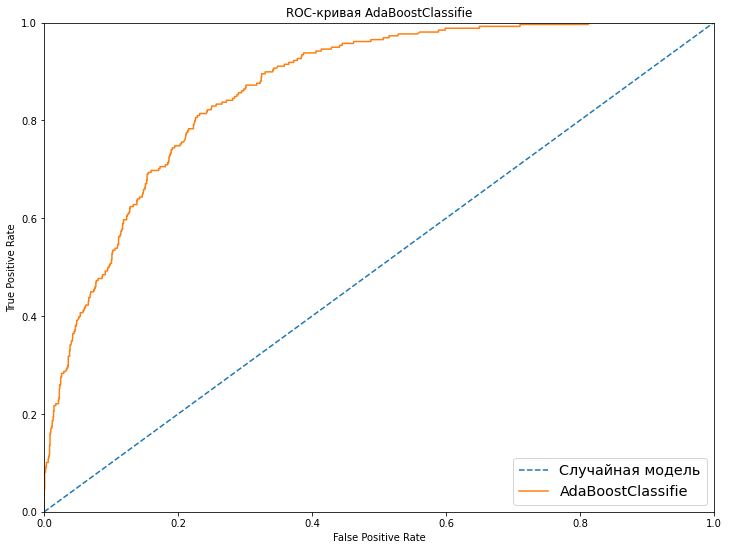

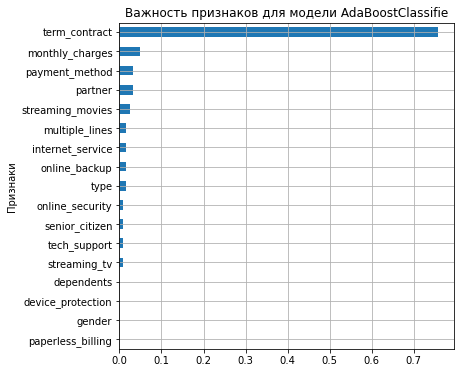

In [67]:
roc_auc_ada, f1_ada, accuracy_ada, best_ada_model = grid_model(ada_boost, ada_params, 'AdaBoostClassifie')

In [68]:
index_table += 1
table.loc[index_table] = ['AdaBoostClassifier', roc_auc_ada, accuracy_ada, f1_ada]
table

,Модель,AUC_ROC,Accuracy,F1
1,RandomForestClassifier,0.820470,0.847217,0.093732
2,RandomForestClassifier+balanced,0.821483,0.787959,0.496057
3,LGBMClassifier,0.903137,0.916129,0.685272
4,LGBMClassifier+balanced,0.897622,0.878834,0.650486
5,CatBoostClassifier,0.926303,0.925404,0.721808
6,XGBClassifier,0.887887,0.895682,0.582395
7,AdaBoostClassifier,0.839191,0.864066,0.441959


Наиболее важным признаком для этой модели является длительность контракта.

**Вывод:**

 Были обучены 5 моделей и подобраны лучшие гиперпараметры для них. 
 * При обучении моделей RandomForesterClassifier и LGBMClassifier было проверено влияние дисбаланса на показатели метрики. Выяснилось, что учет дисбаланса не сильно влияет на целевую метрику AUC_ROC, поэтому при обучении остальных моделей было принято решение не использовать его дальше.
 
 * При анализе важности признаков практически для всех моделей самым важным признаком оказался длительность контракта и ежемесячный платеж. А вот для модели XGBClassifier	наиболее важным признаком оказался тип договора, наличие многоканального подлючения во время звонка и наличие партнера. При этом для модели XGBClassifier все признаки важны в большей степени, чем для остальных.
 
 * Наилучшие показатели оказались у модели catBoostClassifier:
               * AUC_ROC - 0.926303
               * Accuracy - 0.925404
               * F1 - 0.721808
 Эти результаты были получены у модели со следующими параметрами:
               * iterations : 500
               * depth : 3 
               * learning_rate : 0.2
               * l2_leaf_reg : 1
 Именно эта модель будет использована для проверки результатов на тестовый выборки.

<a id='part_6'></a>
# Тестирование отобранной модели

Прежде чем приступить к тестированию, создадим таблицу для удобства сравнения результатов на обучающей выборке и тестовой.

In [69]:
index_table_final = 0
table_final = pd.DataFrame(columns=['Результаты CatBoostClassifier','AUC_ROC', 'Accuracy', 'F1'])

index_table_final +=1
table_final.loc[index_table_final] = ['Обучающая выборка', roc_auc_cat, accuracy_cat, f1_cat]
table_final

,Результаты CatBoostClassifier,AUC_ROC,Accuracy,F1
1,Обучающая выборка,0.926303,0.925404,0.721808


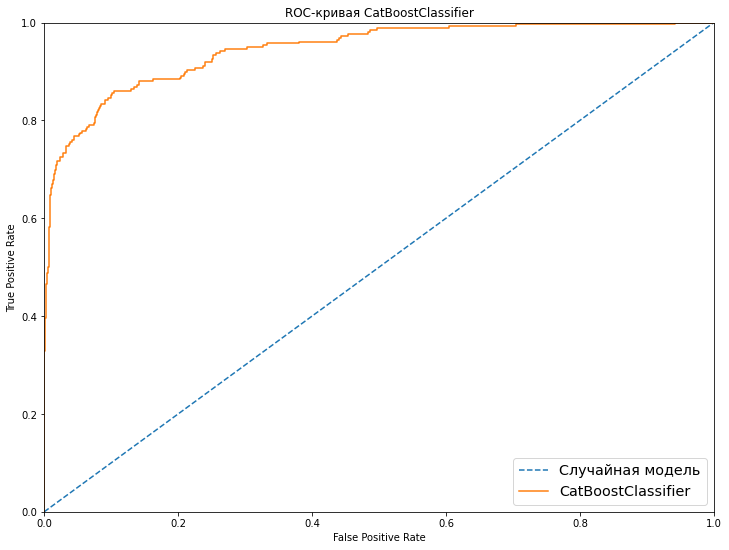

In [70]:
final_predict = best_cat_model.predict(features_test_te)

probabilities_test = best_cat_model.predict_proba(features_test_te)[:,1]


auc_roc_final = roc_auc_score(target_test, probabilities_test)
f1_final = f1_score(target_test, final_predict, zero_division=0)
accuracy_final = accuracy_score(target_test, final_predict)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_test)

roc_plot(fpr, tpr, 'CatBoostClassifier')
plt.show()

In [71]:
index_table_final +=1
table_final.loc[index_table_final] = ['Тестовая выборка', auc_roc_final, accuracy_final, f1_final]
table_final

,Результаты CatBoostClassifier,AUC_ROC,Accuracy,F1
1,Обучающая выборка,0.926303,0.925404,0.721808
2,Тестовая выборка,0.943905,0.940943,0.768889


Ключевая метрика на тестовой выборке немного улучшила результаты. По условию задачи нам необходимо было получить результаты AUC_ROC не меньше 0.85. Отобранная модель на тестовой выборке показала результат 0.94. 

Посмотрим матрицу путаницы итоговой модели.

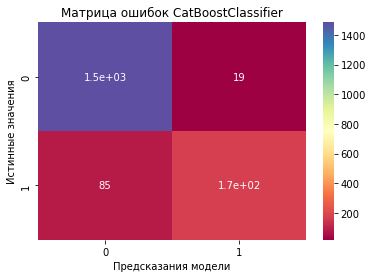

In [72]:
matrix = sns.heatmap(confusion_matrix(target_test, final_predict), 
                     annot=True,
                     cmap="Spectral")
matrix.set(title="Матрица ошибок CatBoostClassifier", xlabel='Предсказания модели', ylabel='Истинные значения')
plt.show()

Модель чаще всего дает ошибочное предположение в предсказании оттока клиентов. Возможно все таки стоит обратить внимание учет дисбаланса данных.

<a id='part_7'></a>
# Вывод

 **Цель исследования:** прогнозирование оттока клиентов компании. 
 
 
 **Ключевая метрика:** AUC_ROC. По условию данная метрика дожна быть выше 0.85.
 
 **Исходные данные:**
 
  Представлены в 4 датафреймах и актуальный на 1 февраля 2020 год: 
 * Информация о договорах
 * Персональные данные клиентов
 * Информация об интернет-услугах
 * Информация об услугах телефонии
 
 
 **Описание полей:**
 
 * BeginDate - дата начала пользования услугами.
 * EndDate - дата окончания пользования услугами.
 * Type - тип оплаты: ежемесячный, годовой и т.д.
 * PaperlessBilling - электронный платежный документ
 * PaymentMethod - способ оплаты.
 * MonthlyCharges - ежемесячные траты на услуги
 * TotalCharges - всего потрачено денег на услуги
 * Dependents - наличие иждивенцев
 * Senior Citizen - наличие пенсионного статуса по возрасту
 * Partner - наличие супруга(и)
 * MultipleLines - наличие возможности ведения параллельных линий во время звонка.
 * gender - пол клиента
 
 
 **Первичный анализ и предобработка:**
 
 Названия столбцов были приведены к единому общепринятому стилю написания. Явных дубликатов и пропусков в столбцах не обнаружено. В столбце TotalCharges были обнаружены неявные пропуски в виде пробелов. Данные пропуски были заменены на нулевое значение. 
 
 Был создан единый датафрейм размером 12 столбцов и 7043 строк. Исходные данные обьединили по столбцу CustomerId. Поскольку в датафреймах было разное количество данных, то после соединения образовались пропуски:
 
 * информация об интеренет-услугах     1526 пропусков
 * информация о телефонии        682 пропусков.
 
 Поскольку данные пропуски означали, что данные клиенты не пользуются этим видом услуг, то было принято решение заполнить их значениями 'No internet' и 'No phone' соответственно. В столбце 'EndDate' для действующих клиентов присутствовало значение 'No', которое было заменено датой актуальности данных и сфомирован целевой признак: 
 
 
 * клиент ушел (1)
 * клиент остался (0)
 
 Добавлен новый признак длительность контракта.
 
 
**Анализ данных:**

* Количество клиентов, которые расторгли договор с компанией с 2015 по 2019 имеет небольшой ежегодный прирост. При этом с 2019 года наблюдается увеличение числа клиентов новых клиентов. При этом число действующих клиентов значительно превышает число оттока клиентов.

* Большинство клиентов не имеют детей и не достигли пенсионного возраста. Наиболее популярный тип договора с ежемесячной оплатой без использования дополнительных услуг. При этом клиенты предпочитают получать электронный платежный документ и с его помощью оплачивать предоставляемые услуги компании. Мужчин и женщин среди клиентов примерно поравну.

* Наиболее популярный способ подключения интернета - оптоволокно. Клиенты, использующие такой вид подключение интернета чаще отказываются от услуг компании. Возможно проблема в качестве предоставляемой услуги: низнакая скорость интернета, плохая техподдержка.

* Клиенты, получающие электронный платежный документ чаще отказываются от услуг компании. Возможно это связано с тем, что получая и оплачивая услуги по безналу расчету подразумевает наличие личного кабинета, в котором можно легко расторгнуть договор. Гендерный признак не оказывает существенного влияния на отказ клиента от услуг компании., а вот наличие партнера повышает шансы отказа от услуг.

* С увеличением ежемесячного платежа шансы того, что клиент уйдет повышаются. Наблюдается повышенное число ушедших клиентов с минимальными ежемесячными затратами. Возможно в этом числе имеются молодые люди(например, студенты), которые нашли компанию с наиболее выгодным предложением или более низкой стоимостью услуг.

* Сформулирована и подтверждена гипотеза, что в среднем клиенты отказываются от услуг компании в течении 3 лет с момента заключения договора.

* Построена матрица корреляции признаков, которая показала сильную взаимосвязь даты заключения контракта и длительности контракта, а также даты рассторжения контракта и целевого признака. Так же наблюдается достаточно сильная взаимосвязь между собой некоторых признаков(например ежемесячный платеж - итоговая сумма, ежемесячный платеж - дополнительные услуги). В результате этого было принято решение удалить столбцы с датами заключения-расторжения договора и итоговой суммой затрат.

**Подготовка данных к обучению:**

* Данные разделены на обучающую и тестовую выборки в соотношении 3:1 (75% и 25%)

* Выделены признаки и целевой (type_client)

* В целевом признаке присутствует дисбаланс.
* Из-за присутствия категориальных признаков была проведена кодировка данных с применением метода TargetEncoder.


**Обучение моделей и тестирование итоговой:**

* Для обучения отобрали 5 моделей:

             * RandomForestClassifier
             * CatboostClassifier
             * LGBMClassifier
             * XGBClassifier
             * AdaBoostClassifier

* При обучении и подборе гиперпараметров применялись StandardScaler(), Pipeline() и GridSearch().

* Все модели RandomForestClassifier и AdaBoostClassifier выдали наихудшие результаты среди всех моделей:
      
      * AUC-ROC для модели RandomForestClassifier - 0.820470
      * AUC-ROC для модели AdaBoostClassifier - 0.839191
      
 Данные результаты имеют значение ниже установленного значения AUC-ROC 0.85.
 
 * Наилучшие результаты на обучающей выборке показала модель CatBoostClassifier (AUC-ROC - 0.926303). Данный результат был получен со следующими параметрами:
      
      * iterations : 500
      * depth : 3 
      * learning_rate : 0.2
      * l2_leaf_reg : 1
      * random_state : 240323
      * cv : 5

* На тестовой выборке модель CatBoostClassifier с данными параметрами выдала результат:
    
     * AUC_ROC - 0.943905
     * Accuracy	- 0.940943
     * F1 - 0.768889
     
 Данные результаты удовлетворяют заявленным требованиям, поэтому ее можно рекомендовать клиенту для решения его бизнес-задачи.
